In [1]:
using Revise
using GLMakie
using FileIO
using Interpolations

pathBase = joinpath(@__DIR__, "../src/")

includet(pathBase * "SimMain.jl")
includet(pathBase * "Visualization.jl")
includet(pathBase * "ReactAdvDiff.jl")
includet(pathBase * "Mechanics.jl")
includet(pathBase * "LightControl.jl")
includet(pathBase * "SharedStructs.jl")
using .SharedStructs
includet(pathBase * "MathFunctions.jl")
using .MathFunctions

using .SharedStructs


In [112]:
function ReturnInterpolateFunction(rDomain, values, factor)
    dr = rDomain[2] - rDomain[1]
    rMaxm1 = rDomain[end]
    drNew = dr / factor
    newRDomain = collect(0:drNew:(rDomain[end]))
    itp = interpolate(values, BSpline(Cubic(Line(OnGrid()))))
    return scale(itp, 0:dr:(rMaxm1))
end

function InterpolateFunction(rDomain, values, factor)
    iFunc = ReturnInterpolateFunction(rDomain, values, factor)
    return (newRDomain, iFunc.(newRDomain))
end


function runningAverage(yVals::Vector{T}, windowSize::Int) where T
    n = length(yVals)
    yValsAveraged = similar(yVals, T, n - 2 * windowSize)
    
    for i in (windowSize + 1):(n - windowSize)
        total = zero(T)
        
        for j in -windowSize:windowSize
            index = i + j
            total += yVals[index]
        end
        
        # Calculate the average and assign to the result array
        yValsAveraged[i - windowSize] = total / (2 * windowSize + 1)
    end
    
    return yValsAveraged
end

Interp(rDomain, values) = InterpolateFunction(rDomain, values, 5)

linFun(t, p) = p[1] .* t .+ p[2]

function GetClosestEntry(xArray, val)
    return findmin(abs.(xArray .- val))[2]
end

function GetRightmostCloseInd(xArray, val, eps)
    absDiff = abs.(xArray .- val)
    matches = findall(<(eps), absDiff)
    if length(matches) == 0
        return []
    else
        return sort(matches)[end]
    end
end

function GetMinimumInd(xArray, val, eps)
    matches = findmin(xArray)[2]
    return matches
    end

    
CBTot(cFArray) = [(cFArray[t].CBASoA.Values .+ cFArray[t].CBISoA.Values)[1:end] for t in 1:length(cFArray)]

CBTotrz(cFArray) = [sum(Array(cFArray[t].CBASoA.Values) .+ Array(cFArray[t].CBISoA.Values), dims = 2)[1:end] for t in 1:length(cFArray)]

function GetAreaList(cFArray, val, eps, iFac = 10, rz = false)
    if rz
        cValArray = CBTotrz(cFArray)
    else
        cValArray = CBTot(cFArray)
    end
    concVals = cValArray[1]
    rDomain = collect(0:length(concVals)-1)

    areaList = Vector{Float64}([])
    indsList = Vector{Int64}([])
    indsIntList = Vector{Int64}([])

    for t in 1:length(cFArray)
        concVals = cValArray[t]
        (rDomainInt, cInterp) = InterpolateFunction(rDomain, concVals, iFac)
        inds = GetRightmostCloseInd(cInterp, val, eps)
        #inds = GetMinimumInd(cInterp, val, eps)
        if length(inds) == 0
            rst = 0.0
            ind = 1
            indInt = 1
        else
            rst = rDomainInt[inds[end]]
            ind = Int(floor(inds[end] / iFac)) + 1
            indInt = inds[end]
        end
        push!(areaList, pi * rst^2)
        push!(indsList, ind)
        push!(indsIntList, indInt)
    end
    
    return (indsList, indsIntList, areaList)
end

function ExpandForGhostPoints(field)
    n = length(field)
    newField = zeros(n + 4)
    newField[3:end-2] .= field
    
    newField[1] = 2 * field[1] - field[3] 
    newField[2] = 2 * field[1] - field[2]
    newField[end-1] = 2 * field[end] - field[end-1]
    newField[end] = 2 * field[end] - field[end-2]
    
    return newField
end

function FirstOrderDerivative(field, dr, neu = false)
    N = length(field)
    result = similar(field)

    if neu
        expField = ExpandForGhostPoints(field)
        @inbounds for ip in 1:N
            i = ip + 2
            result[ip] = (expField[i+1] - expField[i-1]) / (2 * dr)
        end
    else 
        @inbounds for i in 2:N-1
            result[i] = (field[i+1] - field[i-1]) / (2 * dr)
        end

        # Boundary conditions (assuming periodic boundary conditions)
        result[1] = (field[2] - field[N]) / (2 * dr)
        result[N] = (field[1] - field[N-1]) / (2 * dr)
    end

    return result
end

function GetVelocity(parameters, dFArray)
    numT = length(dFArray)
    uxVals = [dFArray[t].uxSoA.Values[1:end] for t in 1:numT]
    numX = length(uxVals[1][1:end])
    vxs = []
    delT = parameters["timeStride"] * parameters["dt"]
    for x in 1:numX
        ux = [uxVals[t][x] for t in 1:numT]
        vx = FirstOrderDerivative(ux, delT)
        push!(vxs, deepcopy(vx))
    end
    vxVals = [[vxs[x][t] for x in 1:numX] for t in 1:numT]
    return vxVals
end

function GetvxArray(parameters, dFArray)
    vxArray = zeros((length(dFArray)-1, length(dFArray[1].uxSoA.Values[1:end,1])))
    delT = parameters["timeStride"] * parameters["dt"]
    for t = 1:(length(dFArray) - 1)
            vxArray[t,1:end] .= (dFArray[t+1].uxSoA.Values[1:end,1] .- dFArray[t].uxSoA.Values[1:end,1]) ./ delT
    end 
    return vxArray
end


FVF(vec) = Vector{Float64}(vec)

function GetTimeDomain(parameters, cFArray)
    return FVF(collect(0:(length(cFArray)-1)) .* parameters["dt"]*parameters["timeStride"])
end


function GetiFun(parameters, cFArray)
    tRange = GetTimeDomain(parameters, cFArray)
    iFun = LightControl.getiFun(parameters["cyc"], parameters["len"], parameters["del"], parameters["nSteps"] * parameters["dt"])
    return (tRange, iFun)
end

function Convertrtoxy(rValues, rDomain, nx, ny)
    arr = zeros((nx,ny))
    mid = [nx/2, ny/2]
    iFunc = ReturnInterpolateFunction(rDomain, rValues, 20) 
    for j in 1:ny, i in 1:nx
        rVec = [i - mid[1], j - mid[2]]
        r = sqrt(rVec[1]^2 + rVec[2]^2)
        arr[i,j] = iFunc(r)
    end 
    return arr
end
        

function MakeKymograph(rValArray)
    nt = length(rValArray)
    nr = length(rValArray[1])
    arr = zeros((nt, nr))
    for t in 1:nt
        arr[t,:] .= rValArray[t]
    end 
    return arr
end 

function VectorNorm2D(a)
  return sqrt(a[1] * a[1] +  a[2] * a[2])
end

function ConvertToRadialVectors(arr, skip, fac)
    dims = size(arr)
    xRange = collect(1:skip:dims[1])
    yRange = collect(1:skip:dims[2])
    mid = [dims[1]/2, dims[2]/2]
    nxs = []
    nys = []
    nus = []
    nvs = []
    for i = 1:skip:dims[1]
        for j = 1:skip:dims[2]
            push!(nxs, i)
            push!(nys, j)
            rOff = [i,j] .- mid
            rOff = rOff ./ VectorNorm2D(rOff)
            r = fac * arr[i,j]
            rVec = rOff .* r
            push!(nus, rVec[1])
            push!(nvs, rVec[2])
        end 
    end
    
    return (nxs, nys, nus, nvs)
end

# function ConvertToRadialVectorsRad(rDomain, rValues, skip, rMax, fac, mid)
#     rRange = rDomain[1:skip:end]
#     tRange = collect(0:(pi/20):2*pi)
#     iFunc = ReturnInterpolateFunction(rDomain, rValues, 20) 
#     nxs = []
#     nys = []
#     nus = []
#     nvs = []
#     for r in rRange
#         for t in tRange
#             rOff = r .* [cos(t), sin(t)]
#             (x,y) = rOff .+ mid
#             push!(nxs, x)
#             push!(nys, y)
#             rnew = fac * iFunc(r)
#             rVec = rOff .* rnew
#             push!(nus, rVec[1])
#             push!(nvs, rVec[2])
#         end 
#     end
    
#     return (nxs, nys, nus, nvs)
# end
    

ConvertToRadialVectors (generic function with 2 methods)

In [23]:
## visualize the star - create snapshots

pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_Mod/Dirs_r0_star_fin"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_Mod/Dirs_r0_100s_fin1"


r0 = 50.0

pathName = pathBase * "/r0_" * string(r0) * "/" 


d = load(pathName * "SavedData.jld2")

parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];

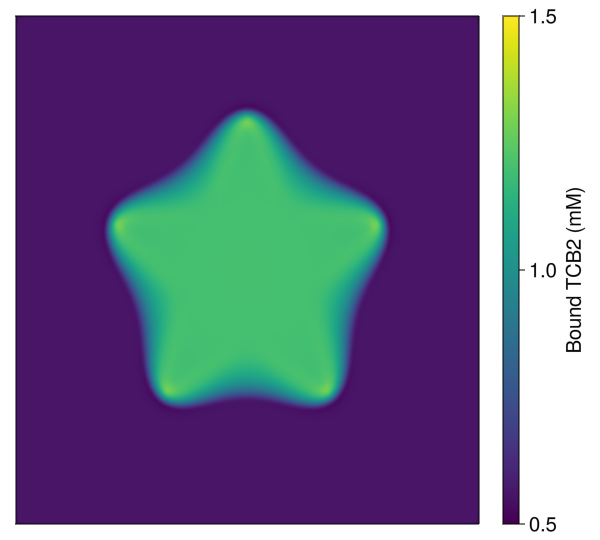

In [9]:
res = 600
ar = 0.9
fontsize = 20

f = Figure(resolution = (res, ar * res), fontsize = fontsize, font = "Arial", dpi = 300)

xlabel = "r Position (𝜇m)";
ylabel = "z Position (𝜇m)";
ticks = [25, 125, 225]
tickLabels = ["-100", "0", "100"]

ax = Axis(f[1, 1],
    xlabel = xlabel,
    ylabel = ylabel
    #xticks = (ticks, tickLabels),
    #yticks = (ticks, tickLabels)
)


t = 6

hm = Makie.heatmap!(cFArray[t].CBASoA.Values .+ cFArray[t].CBISoA.Values, interpolate = true, colorrange = (0.5, 1.5))
#hm = Makie.heatmap!(cFArray[t].CCSoA.Values, interpolate = true)
Makie.Colorbar(f[1,2], hm, label = "Bound TCB2 (mM)")

hidedecorations!(ax, grid = false)

figurePath = "/Users/csfloyd/Dropbox/Projects/TCB2Network/ModelDataForPaper/Figures/"
save(figurePath * "StarPattern.png", f, px_per_unit = 3)

current_figure()

In [3]:
pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_Mod/Dirs_r0_100s_rz"
#pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_Mod/Dirs_r0_100s_fin1"


r0 = 50.0

pathName = pathBase * "/r0_" * string(r0) * "/" 


d = load(pathName * "SavedData.jld2")

parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];

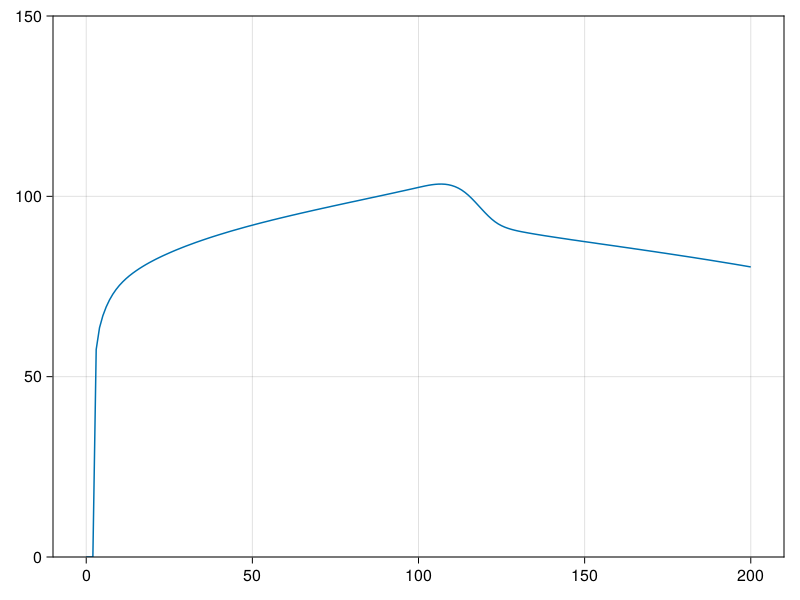

In [98]:
xs = GetTimeDomain(parameters, cFArray) 
(indsList, indsIntList, areaList) = GetAreaList(cFArray, 50, 0.5, 100, true)#.^ (0.5)
ys = sqrt.(areaList ./ pi) 
Makie.lines(xs, ys)
Makie.ylims!(0,150)
current_figure()

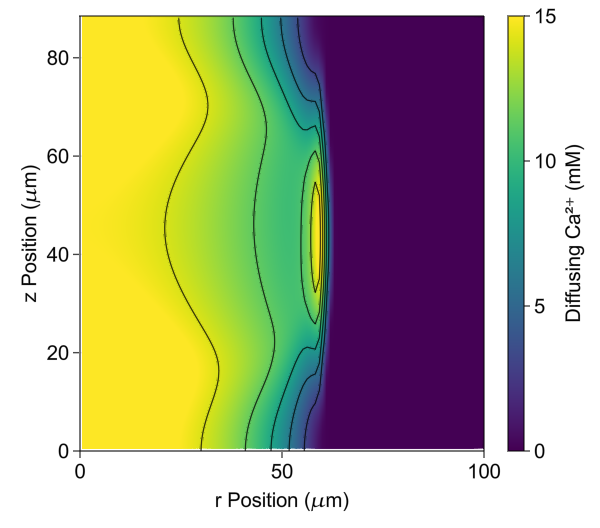

In [114]:
res = 600
ar = 88 / 100
fontsize = 20

f = Figure(resolution = (res, ar * res), fontsize = fontsize, font = "Arial", dpi = 300)

xlabel = "r Position (𝜇m)";
ylabel = "z Position (𝜇m)";
ticks = [25, 125, 225]
tickLabels = ["-100", "0", "100"]

ax = Axis(f[1, 1],
    xlabel = xlabel,
    ylabel = ylabel
    #xticks = (ticks, tickLabels),
    #yticks = (ticks, tickLabels)
)

t = 2
#(0.06,maximum(vals))
#vals = cFArray[t].CBASoA.Values .+ cFArray[t].CBISoA.Values
vals = cFArray[t].CCSoA.Values
#hm = Makie.heatmap!(cFArray[t].CBASoA.Values .+ cFArray[t].CBISoA.Values, interpolate = true, colorrange = (1,2))
hm = Makie.heatmap!(vals, interpolate = true, colorrange = (0,15), levels = 20, colormap = :viridis)
Makie.contour!(vals, interpolate = true, colorrange = (0,15), linewidth = 1, color = :black)
Makie.Colorbar(f[1,2], hm, label = "Diffusing Ca²⁺ (mM)")
Makie.xlims!(0,100)

current_figure()

In [31]:
pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_Mod/Dirs_r0_MC_fin"


r0 = 25.0

pathName = pathBase * "/r0_" * string(r0) * "/" 


d = load(pathName * "SavedData.jld2")

parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];


LoadError: ArgumentError: No file exists at given path: /Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_Mod/Dirs_r0_MC_fin/r0_25.0/SavedData.jld2

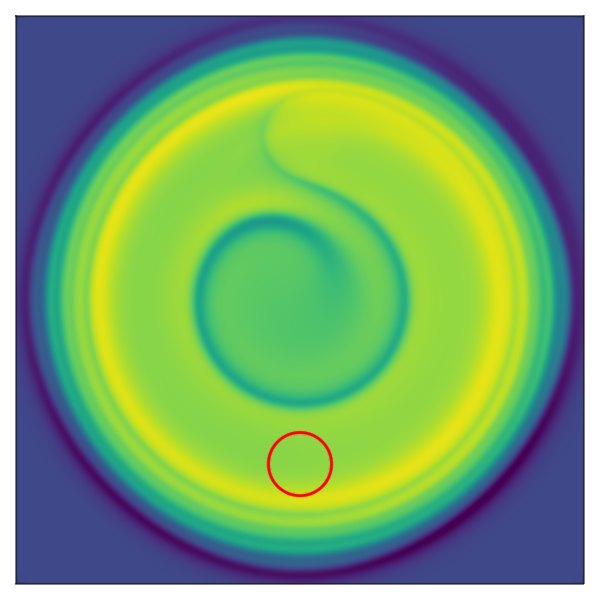

In [22]:
## visualize the circular motion - create snapshots

res = 600
ar = 1
fontsize = 20

f = Figure(resolution = (res, ar * res), fontsize = fontsize, font = "Arial", dpi = 300)

xlabel = "x Position (𝜇m)";
ylabel = "y Position (𝜇m)";
ticks = [25, 125, 225]
tickLabels = ["-100", "0", "100"]

ax = Axis(f[1, 1],
    #xlabel = xlabel,
    #ylabel = ylabel,
    #xticks = (ticks, tickLabels),
    #yticks = (ticks, tickLabels)
)

#Makie.heatmap(dFArray[end].uxSoA.Values.^2 .+ dFArray[end].uySoA.Values.^2)

t = 45 #, 5, 13, 45

function rotateFunc(array)
    rotated_matrix = rotr90(rotr90(rotr90(array)))
end

hm = Makie.heatmap!((cFArray[t].CBASoA.Values .+ cFArray[t].CBISoA.Values) |> rotateFunc, interpolate = true, colorrange = (0.5, 1.5))

#hm = Makie.heatmap!((cFArray[t].CCSoA.Values) |> rotateFunc, interpolate = true, colorrange = (0, 5*1.5))
#Makie.Colorbar(f[1,2], hm, label = "Bound TCB2 (mM)")

R = 130
r0 = 25 
s = 2
omega = 1/8
nh = 300
cent = LightControl.circleTimeFunc(R, t - 1 - 2, omega) .+ [nh, nh]
arc!(Point2f(cent), r0, -π, π, color = :red, linewidth = 3)

off = 75
Makie.xlims!(off, 600 - off)
Makie.ylims!(off, 600 - off)

hidedecorations!(ax)

figurePath = "/Users/csfloyd/Dropbox/Projects/TCB2Network/ModelDataForPaper/Figures/"
#save(figurePath * "CircularMotionT3.png", f, px_per_unit = 3)

current_figure()

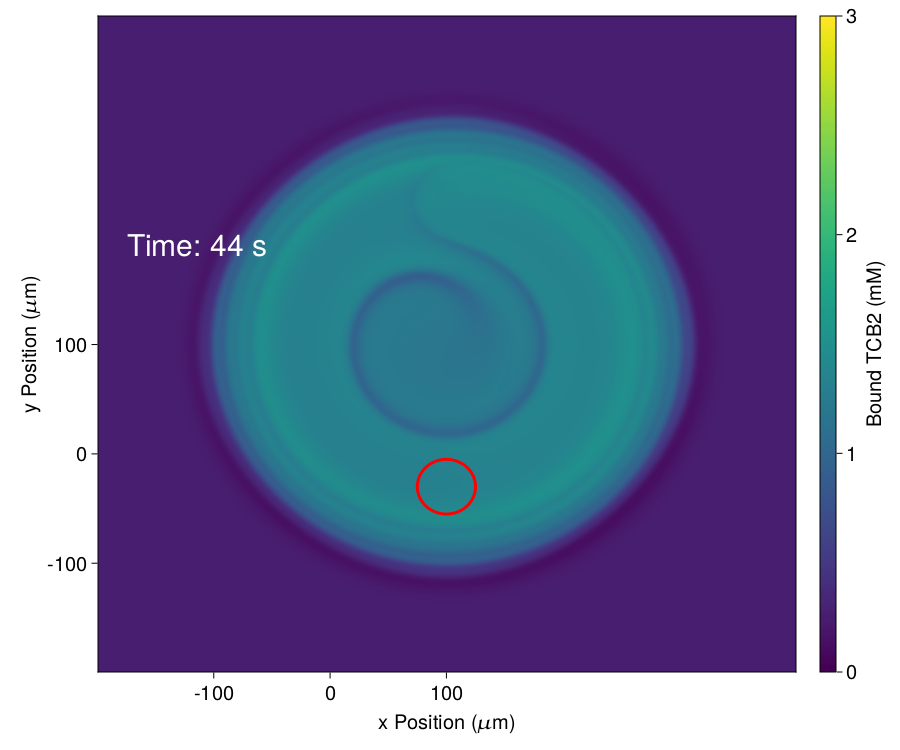

In [48]:
## animate 2d movie of circular motion

using CairoMakie
res = 750 
fontsize = 20

ticks = [100, 200, 300]
tickLabels = ["-100", "0", "100"]

f = Figure(resolution = (1.2*res, res), fontsize = fontsize, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "x Position (𝜇m)",
    ylabel = "y Position (𝜇m)",
    xticks = (ticks, tickLabels),
    yticks = (ticks, tickLabels)
)

function rotateFunc(array)
    return rotr90(rotr90(rotr90(array)))
#    return array
end

t = 1

v = Observable(rotateFunc(cFArray[t].CBASoA.Values .+ cFArray[t].CBISoA.Values))

R = 130
r0 = 25 
s = 2
omega = 1/8
nh = 300
cent = Observable(Point2f(LightControl.circleTimeFunc(R, t-1, omega) .+ [nh, nh]))


hm = Makie.heatmap!(v, interpolate = true, colorrange = (0, 3))
Makie.Colorbar(f[1,2], hm, label = "Bound TCB2 (mM)")

time = Observable("Time: " * string(t-1) * " s")
arc!(cent, r0, -π, π, color = :red, linewidth = 3)
text!(25, 375, text = time, color = :white, fontsize = 30)

moviePath = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Movies/JuliaMovies/CircularTrajectoryNew.mp4"
record(f, moviePath, 1:length(CBTot(cFArray)), framerate = 5) do t
    v[] = rotateFunc(cFArray[t].CBASoA.Values .+ cFArray[t].CBISoA.Values)
    cent[] = Point2f(LightControl.circleTimeFunc(R, t - 1 - 2, omega) .+ [nh, nh])
    time[] = "Time: " * string(t-1) * " s"
end
    
current_figure()

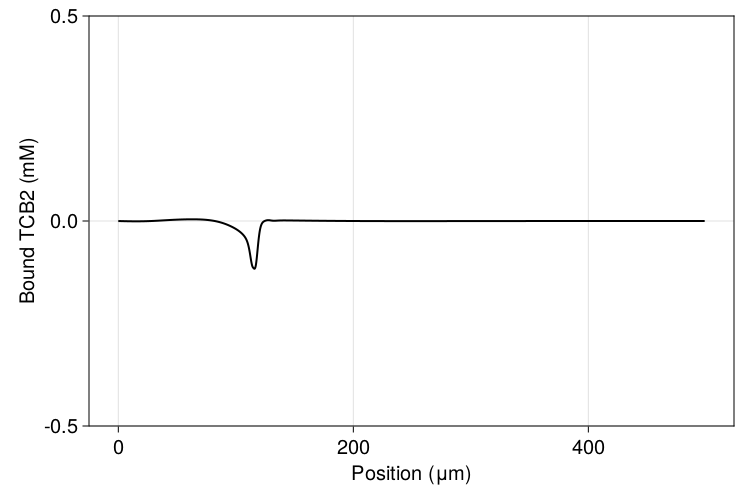

In [36]:
using CairoMakie
res = 750 
fontsize = 20

iFac = 100

f = Figure(resolution = (res, 2*res/3), fontsize = fontsize, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "Position (μm)",
    ylabel = "Bound TCB2 (mM)"
)

d = dList[2]
parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];

#concVals = CBTot(cFArray)

concVals = GetVelocity(parameters, dFArray)

# concVals = CBTotrz(cFArray)

#concVals = [(cFArray[t].CDASoA.Values .+ cFArray[t].CDISoA.Values)[1:end] for t in 1:length(cFArray)]
#concVals = [(cFArray[t].CCSoA.Values)[1:end] for t in 1:length(cFArray)]

rDomain = collect(0:length(concVals[1])-1)
rDomainInt = InterpolateFunction(rDomain, concVals[1], iFac)[1]

t = 1
cVals = Observable(InterpolateFunction(rDomain, concVals[t], iFac)[2][1:end])
CairoMakie.lines!(rDomainInt, cVals, color = :black, linewidth = 2)
#Makie.ylims!(0,5)


Makie.ylims!(-0.5,0.5)

#(inds, indsInt, ys) = GetAreaList(cFArray, 0.35, 0.05, 5)
(inds, indsInt, ys) = GetAreaList(cFArray, 0.9, 0.01, iFac)

xScat = Observable(rDomainInt[indsInt[1]])
yScat = Observable(cVals[][indsInt[1]])
#Makie.scatter!(xScat, yScat, color = :red, markersize = 20)

r0 = d["parameters"]["r0"]
(tRange, iFun) = GetiFun(parameters, cFArray)
op = Observable((:red, iFun(tRange[1])))
vspan!([0], [r0], color = op)

moviePath = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Movies/JuliaMovies/30s_vr_fin.mp4"
record(f, moviePath, 1:(length(concVals) - 2), framerate = 60) do t
    cVals[] = InterpolateFunction(rDomain, concVals[t], iFac)[2][1:end]
    op[] = (:red, iFun(tRange[t]))
    #xScat[] = rDomainInt[indsInt[t]]
    #yScat[] = cVals[][indsInt[t]]
end
    
current_figure()



In [3]:
#pathBase = pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_Mod/Dirs_r0_100s_newc/"
pathBase = pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/Dirs/Dirs_Mod/Dirs_r0_100s_fin/"
dList = []
r0Vec = [25, 50, 75, 100, 125, 150] ./ 2
r0Vec = [50, 75, 100] ./ 2
    

for r0 in r0Vec
    pathName = pathBase * "/r0_" * string(r0)  * "/"
    try
        d = load(pathName * "SavedData.jld2");
        push!(dList, d)
    catch ex
        println(r0)
    end
end



In [6]:
length(cFArray)

5001

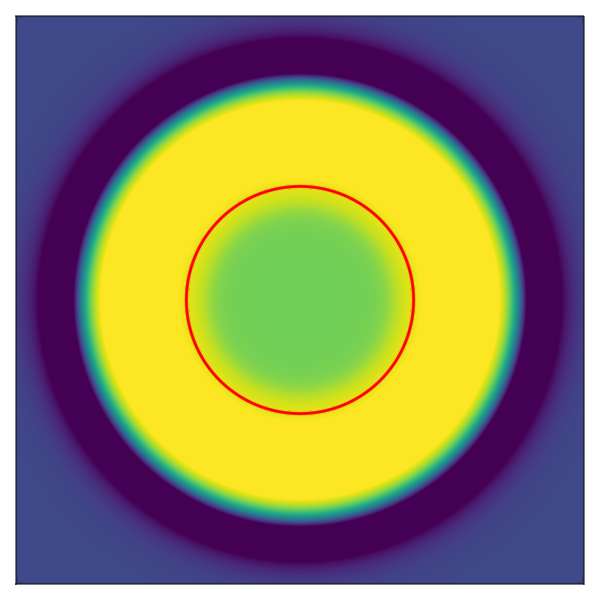

In [18]:
## visualize the 2d growth of 100s


d = dList[2]
parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];

t = 5 * 100

concVals = CBTot(cFArray)[t]
rDomain = collect(0:length(concVals)-1)
(nx, ny) = (600, 600)


arr = Convertrtoxy(concVals, rDomain, nx, ny)## visualize the circular motion - create snapshots

res = 600
ar = 1
fontsize = 20

f = Figure(resolution = (res, ar * res), fontsize = fontsize, font = "Arial", dpi = 300)

xlabel = "x Position (𝜇m)";
ylabel = "y Position (𝜇m)";
ticks = [25, 125, 225]
tickLabels = ["-100", "0", "100"]

ax = Axis(f[1, 1],
    #xlabel = xlabel,
    #ylabel = ylabel,
    #xticks = (ticks, tickLabels),
    #yticks = (ticks, tickLabels)
)


hm = Makie.heatmap!(arr, interpolate = true, colorrange = (0.5, 1.5))
arc!((300, 300), 50, -π, π, color = :red, linewidth = 3)

off = 175
Makie.xlims!(off, 600 - off)
Makie.ylims!(off, 600 - off)

hidedecorations!(ax)

figurePath = "/Users/csfloyd/Dropbox/Projects/TCB2Network/ModelDataForPaper/Figures/"
#save(figurePath * "CircularMotionT3.png", f, px_per_unit = 3)

current_figure()

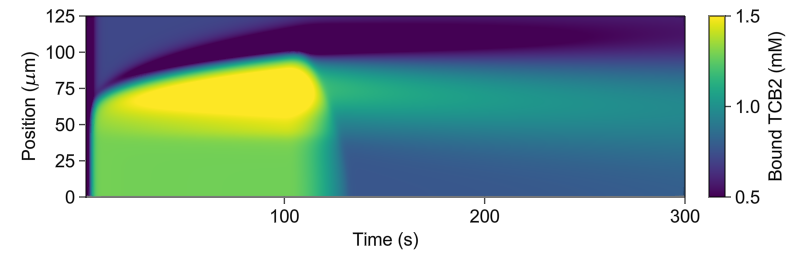

In [40]:
## visualize the kymograph growth of 100s

d = dList[2]
parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];


res = 800
ar = 0.33
fontsize = 18
f = Figure(resolution = (res, ar * res), fontsize = fontsize, font = "Arial", dpi = 300)

xlabel = "Time (s)";
ylabel = "Position (𝜇m)";

xticks = [0, 5 * 100, 5*200, 5*300]
xtickLabels = ["0", "100", "200", "300"]

ax = Axis(f[1, 1],
    xlabel = xlabel,
    ylabel = ylabel,
    xticks = (xticks, xtickLabels)
   #yticks = (yticks, ytickLabels)
)

concVals = CBTot(cFArray)

#concVals = [cFArray[t].CCSoA.Values for t in 1:length(cFArray)]

arr = MakeKymograph(concVals)

hm = Makie.heatmap!(arr, interpolate = true, colorrange = (0.5, 1.5))
Makie.Colorbar(f[1,2], hm, label = "Bound TCB2 (mM)")

Makie.xlims!(5,300 * 5)
Makie.ylims!(0,125)
current_figure()

ConvertToRadialVectorsRad (generic function with 2 methods)

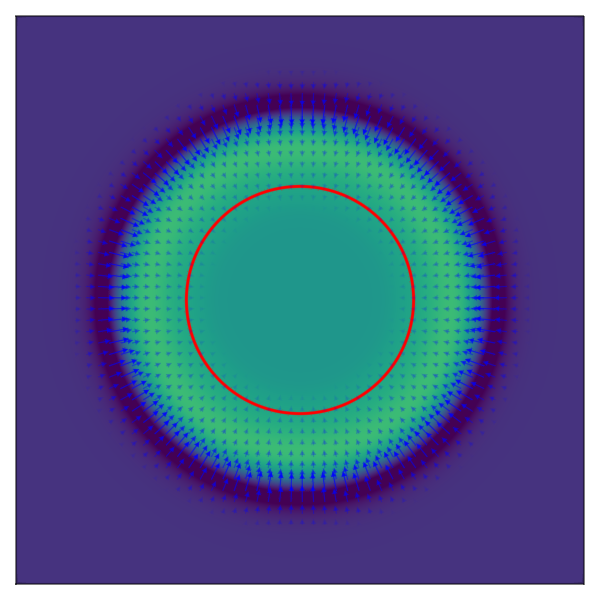

In [111]:
## visualize the 2d growth of 100s

d = dList[2]
parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];

t = 5 * 30


res = 600
ar = 1
fontsize = 20

f = Figure(resolution = (res, ar * res), fontsize = fontsize, font = "Arial", dpi = 300)

xlabel = "x Position (𝜇m)";
ylabel = "y Position (𝜇m)";
ticks = [25, 125, 225]
tickLabels = ["-100", "0", "100"]

ax = Axis(f[1, 1],
    #xlabel = xlabel,
    #ylabel = ylabel,
    #xticks = (ticks, tickLabels),
    #yticks = (ticks, tickLabels)
)

concVals = CBTot(cFArray)[t]
rDomain = collect(0:length(concVals)-1)
(nx, ny) = (600, 600)
arr = Convertrtoxy(concVals, rDomain, nx, ny)
hm = Makie.heatmap!(arr, interpolate = true, colorrange = (0.5, 2), colormap = :viridis)#Reverse(:grays))
arc!((300, 300), 50, -π, π, color = :red, linewidth = 3)


concVals = GetVelocity(parameters, dFArray)[t]
rDomain = collect(0:length(concVals)-1)
(nx, ny) = (600, 600)
arr = Convertrtoxy(concVals, rDomain, nx, ny)

(nxs, nys, nus, nvs) = ConvertToRadialVectors(arr, 5, 50)

cols = [(:blue, log10(VectorNorm2D([nus[t], nvs[t]]))) for t in 1:length(nus)]
arrows!(nxs, nys, nus, nvs, arrowsize = 10, color = cols)

off = 175
Makie.xlims!(off, 600 - off)
Makie.ylims!(off, 600 - off)

hidedecorations!(ax)

figurePath = "/Users/csfloyd/Dropbox/Projects/TCB2Network/ModelDataForPaper/Figures/"
#save(figurePath * ".png", f, px_per_unit = 3)

current_figure()



In [80]:
ops =  [VectorNorm2D([nus[t], nvs[t]]) for t in 1:length(nus)]

14400-element Vector{Float64}:
 8.694771205819422e-74
 1.557683019910358e-72
 2.652400261197756e-71
 4.29165675888638e-70
 6.603874659490796e-69
 9.644837063278618e-68
 1.3408275883947456e-66
 1.7699929022768135e-65
 2.2203450458327463e-64
 2.6503200179566726e-63
 3.008246517348921e-62
 3.2459755075283445e-61
 3.3322367323174514e-60
 ⋮
 7.381217274169702e-60
 7.055633163520404e-61
 6.417892777061366e-62
 5.549071132225435e-63
 4.563030262060204e-64
 3.5708967308677965e-65
 2.653430430456873e-66
 1.873963208689793e-67
 1.2591580726581677e-68
 8.026779055208393e-70
 4.872063946058435e-71
 2.804560042219584e-72

In [81]:
maximum(ops)

15.582668882254469

In [46]:
minimum(arr)

-0.15583345257600334

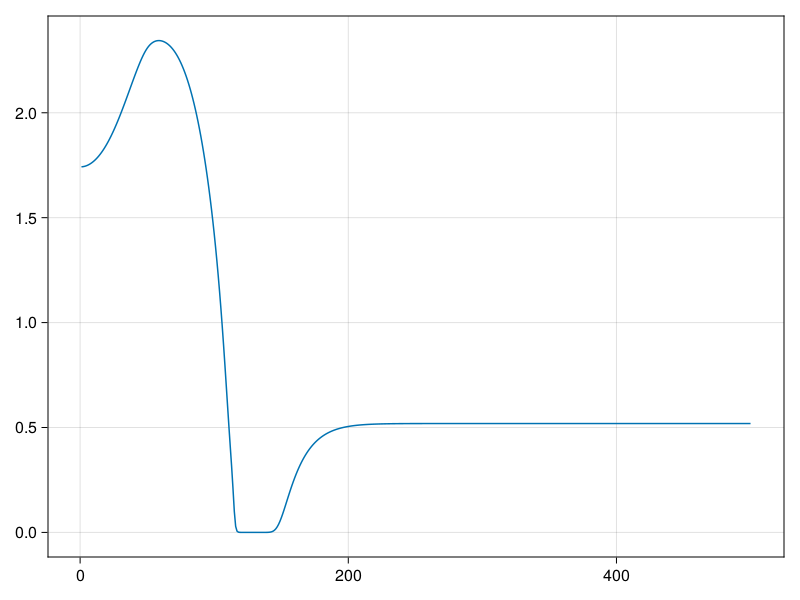

In [12]:
Makie.lines(CBTot(dList[3]["cFArray"])[3000])

var = 25.0
var = 37.5
var = 50.0


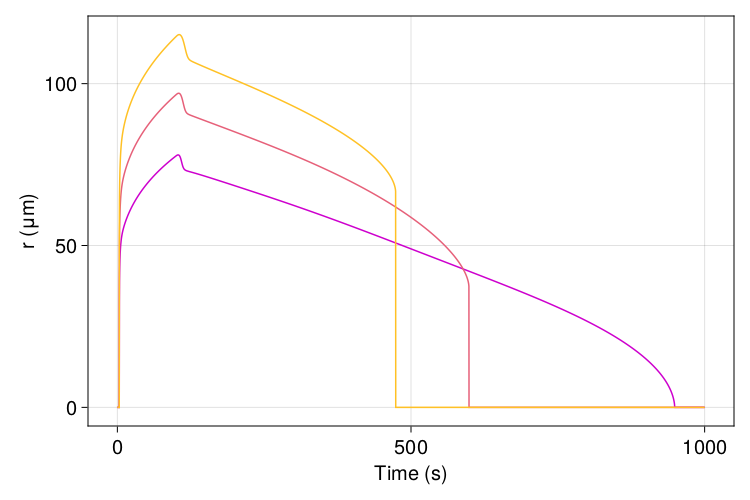

In [63]:
using CairoMakie
using Colors
using LsqFit

res = 750 
fontsize = 20
f = Figure(resolution = (res, 2*res/3), fontsize = fontsize, font = "Arial", dpi = 300)
ax = Axis(f[1, 1],
    xlabel = "Time (s)",
    ylabel = "r (μm)"
)

varVec = r0Vec
#varVec = DDVec
#varVec = DTVec
#varVec = kFacVec
#varVec = CSatVec
#varVec = betaVec
numV = length(varVec)
colors = range(colorant"magenta3", stop=colorant"goldenrod1", length=numV)

first = 200
last = 500

slopeList = FVF([])

for (i, var) in enumerate(varVec) 
    @show var
    d = dList[i]
    parameters = d["parameters"];
    cFArray = d["cFArray"];
    dFArray = d["dFArray"];
    
    xs = GetTimeDomain(parameters, cFArray) #./ 30
    #(inds, indsInt, ys) = GetAreaList(cFArray, 0.35, 0.05, 20)#.^ (0.5)
    (indsList, indsIntList, areaList) = GetAreaList(cFArray, 0.9, 0.01, 100)
    ys = sqrt.(areaList ./ pi) 
    #ys = areaList / (pi * 100)
    #ys = areaList
    
    xVals = xs[first:last] 
    yVals = ys[first:last] 
    fitLin = curve_fit(linFun, xVals, yVals, [1.0, 1e1])
    push!(slopeList, fitLin.param[1])

    
    Makie.lines!(xs, ys, color = colors[i])
#     Makie.lines!(xVals, FVF(linFun(xVals, fitLin.param)), 
#         linewidth = 3, color = (:black, 0.8), linestyle = :dash)
end

#Makie.xlims!(0,300)
#Makie.ylims!(0,150)
current_figure()
    

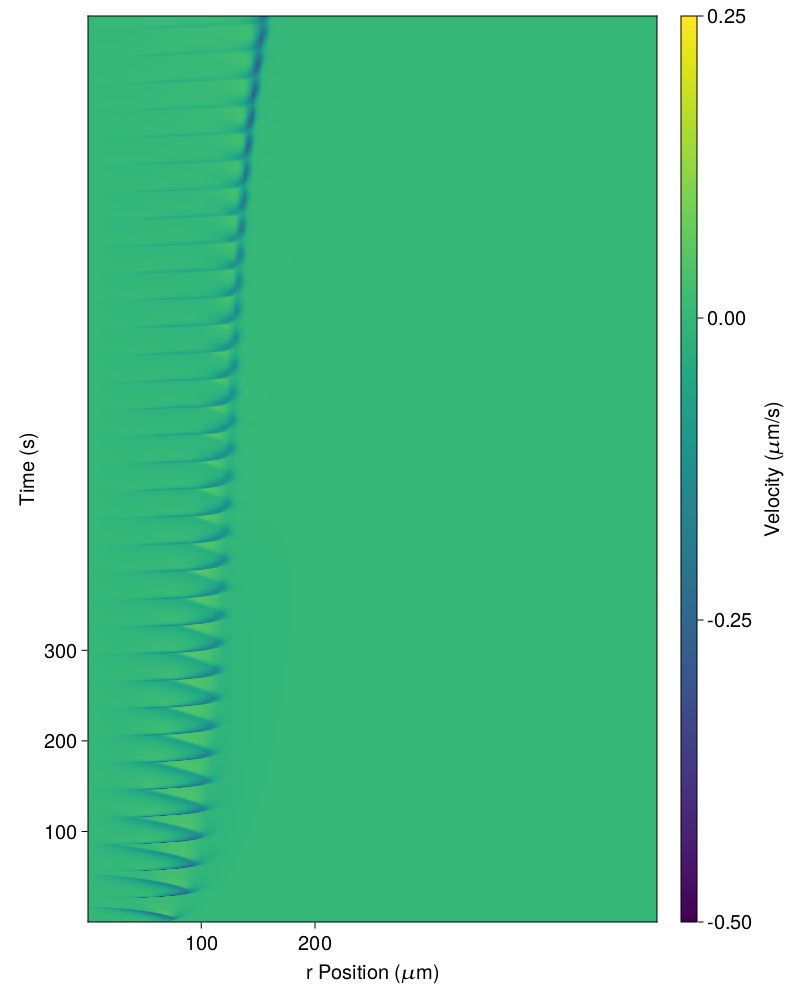

In [34]:
fontsize = 20
res = 1000

f = Figure(resolution = (0.8*res, res), fontsize = fontsize, font = "Arial", dpi = 300)

xlabel = "r Position (𝜇m)";
ylabel = "Time (s)";
xticks = [100, 200,]
xtickLabels = ["100", "200"]

yticks = [500, 1000, 1500]
ytickLabels = ["100", "200", "300"]



ax = Axis(f[1, 1],
    xlabel = xlabel,
    ylabel = ylabel,
    xticks = (xticks, xtickLabels),
    yticks = (yticks, ytickLabels)
)

d = dList[3]
parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];

vxArray = GetvxArray(parameters, dFArray)

hm = Makie.heatmap!(vxArray', colorrange = (-0.5, 0.25))
Makie.Colorbar(f[1,2], hm, label = "Velocity (𝜇m/s)")
#Makie.ylims!(2000,3000)

current_figure()

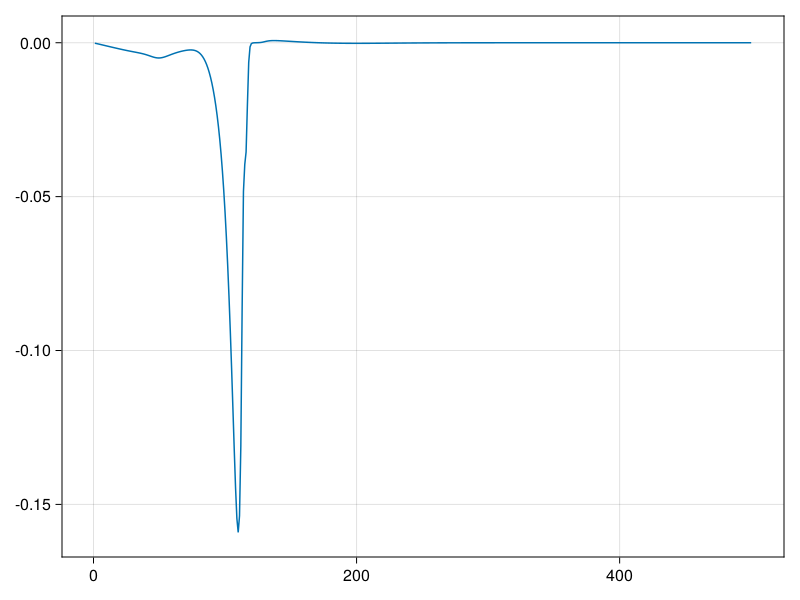

In [133]:
Makie.lines(vxArray[5 * 30 * 15 + 17,1:end])

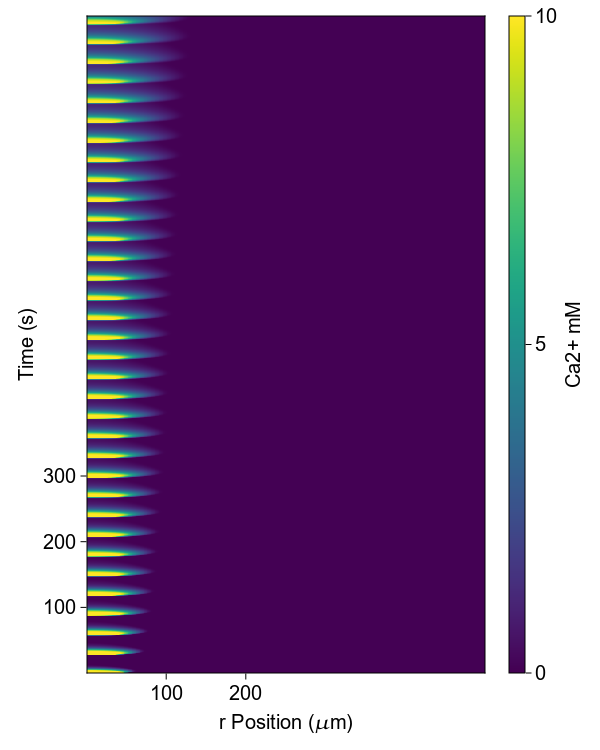

In [107]:
fontsize = 20

f = Figure(resolution = (0.8*res, res), fontsize = fontsize, font = "Arial", dpi = 300)

xlabel = "r Position (𝜇m)";
ylabel = "Time (s)";
xticks = [100, 200,]
xtickLabels = ["100", "200"]

yticks = [500, 1000, 1500]
ytickLabels = ["100", "200", "300"]

delT = parameters["timeStride"] * parameters["dt"]

ax = Axis(f[1, 1],
    xlabel = xlabel,
    ylabel = ylabel,
    xticks = (xticks, xtickLabels),
    yticks = (yticks, ytickLabels)
)

d = dList[2]
parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];

cArray = zeros(length(cFArray), length(cFArray[1].CCSoA.Values[1:end,1]))
for t in 1:length(cArray[:,1])
    cArray[t,1:end] .= cFArray[t].CCSoA.Values[1:end,1] 
end

hm = Makie.heatmap!(cArray', colorrange = (0, 10))
Makie.Colorbar(f[1,2], hm, label = "Ca2+ mM")

current_figure()

xs[t] = 99.8


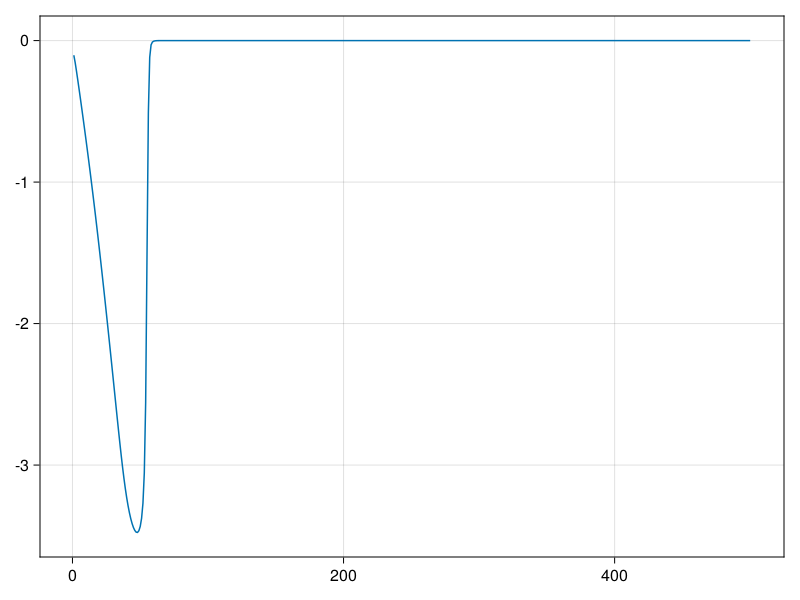

In [56]:
d = dList[1]
parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];
xs = GetTimeDomain(parameters, cFArray)

t = 500
@show xs[t]

Makie.lines(dFArray[t].uxSoA.Values[1:end])

In [41]:
using Pkg
Pkg.instantiate()

In [64]:
## save area data

using DataFrames, CSVFiles, CSV
using DelimitedFiles

pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/ModelDataForPaper/"

subDir = "100s" * "/area/"
varName = "r0"
path = pathBase * subDir * "/"
for (i, var) in enumerate(varVec) 
    d = dList[i]
    parameters = d["parameters"];
    cFArray = d["cFArray"];
    dFArray = d["dFArray"];
    
    xs = GetTimeDomain(parameters, cFArray)
    (indsList, indsIntList, areaList) = GetAreaList(cFArray, 0.9, 0.01, 100)
    
    it = DataFrame(Times_s = xs, Areas_umsq = areaList)
    #it = Dict("vals" => [xs, ys])
    save(path * varName * "_" * string(var) * ".csv", it)
end


In [65]:
## save concentration data

using DataFrames, CSV
using DelimitedFiles

pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/ModelDataForPaper/"

subDir = "100s" * "/concentrations"
varName = "r0"
path = pathBase * subDir * "/"
for (i, var) in enumerate(varVec) 
    d = dList[i]
    parameters = d["parameters"];
    cFArray = d["cFArray"];
    dFArray = d["dFArray"];
    
    xs = GetTimeDomain(parameters, cFArray)
    
    s = (length(cFArray), length(cFArray[1].CDISoA.Values[1:end]))
    DI = zeros(s);
    DA = zeros(s);
    BI = zeros(s);
    BA = zeros(s);
    C = zeros(s);
    D = zeros(s);
    Dst = zeros(s);
    
    for (t, cF) in enumerate(cFArray)
        DI[t,:] .= cF.CDISoA.Values[1:end]
        DA[t,:] .= cF.CDASoA.Values[1:end]
        BI[t,:] .= cF.CBISoA.Values[1:end]
        BA[t,:] .= cF.CBASoA.Values[1:end]
        C[t,:] .= cF.CCSoA.Values[1:end]
        D[t,:] .= cF.CDSoA.Values[1:end]
        Dst[t,:] .= cF.CDstSoA.Values[1:end]
    end
    
    writedlm(path * varName * "_" * string(var) * "/DI.csv", DI, ',')
    writedlm(path * varName * "_" * string(var) * "/DA.csv", DA, ',')
    writedlm(path * varName * "_" * string(var) * "/BI.csv", BI, ',')
    writedlm(path * varName * "_" * string(var) * "/BA.csv", BA, ',')
    writedlm(path * varName * "_" * string(var) * "/C.csv", C, ',')
    writedlm(path * varName * "_" * string(var) * "/D.csv", D, ',')
    writedlm(path * varName * "_" * string(var) * "/Dst.csv", Dst, ',')
    
end


In [66]:
## save disp/vel data

using DataFrames

pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/ModelDataForPaper/"

subDir = "100s" * "/vel"
varName = "r0"
path = pathBase * subDir * "/"
for (i, var) in enumerate(varVec) 
    d = dList[i]
    parameters = d["parameters"];
    cFArray = d["cFArray"];
    dFArray = d["dFArray"];
    
    vr = GetvxArray(parameters, dFArray)
    
    writedlm(path * varName * "_" * string(var) * "/vr.csv", vr, ',')
end

In [67]:
## save iFun data

using DataFrames

pathBase = "/Users/csfloyd/Dropbox/Projects/TCB2Network/ModelDataForPaper/"

subDir = "100s" 
path = pathBase * subDir * "/"

d = dList[1]
parameters = d["parameters"];
cFArray = d["cFArray"];
dFArray = d["dFArray"];

(tRange, iFun) = GetiFun(parameters, cFArray)

tVals = iFun.(tRange)
it = DataFrame(Times_s = tVals, light_intensity = tVals)
save(path * "/lightprotocol.csv", it)

#writedlm(path * "/lightprotocol.csv", tVals, ',')


